In [65]:
# Data manipulation

import numpy as np
import pandas as pd

# Plots

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import cv_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from statsmodels.graphics.tsaplots import plot_pacf


# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

In [66]:
df = pd.read_excel("Veri-Seti.xlsx")

In [67]:
df = df.iloc[:149,:]

In [68]:
df.columns = df.columns.str.lower().str.replace(" ","_")

In [69]:
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df = df.set_index('date')
df = df.asfreq('MS')
df = df.sort_index()

In [70]:
df.head()

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis
date,,,,,
2010-01-01,37.0,13.1820,2.107385,341244.126,20095.0
2010-02-01,37.0,13.2725,2.073890,351940.949,31172.0
2010-03-01,37.0,12.7275,2.085522,361307.320,51769.0
2010-04-01,37.0,12.0120,2.009010,373575.340,54946.0
2010-05-01,37.0,11.7400,1.948870,387708.051,59377.0


In [71]:
df.tail()

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis
date,,,,,
2022-01-01,60.0,28.2500,15.342386,4.794120e+06,38131.0
2022-02-01,60.0,26.8525,15.470000,4.822579e+06,49652.0
2022-03-01,60.0,25.3950,16.080000,4.791176e+06,64267.0
2022-04-01,60.0,24.8220,15.960000,4.814413e+06,60035.0
2022-05-01,65.0,24.2025,16.560000,4.862887e+06,65167.0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149 entries, 2010-01-01 to 2022-05-01
Freq: MS
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   otv_orani       149 non-null    float64
 1   faiz            149 non-null    float64
 2   eur/tl          149 non-null    float64
 3   kredi_stok      149 non-null    float64
 4   otomotiv_satis  149 non-null    float64
dtypes: float64(5)
memory usage: 7.0 KB


In [73]:
df.describe()

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis
count,149.000000,149.000000,149.000000,1.490000e+02,149.000000
mean,43.697987,16.034380,4.808703,1.787554e+06,65902.617450
std,5.846811,5.319518,3.321767,1.176366e+06,26175.801077
min,37.000000,9.607500,1.927305,3.412441e+05,14373.000000
25%,40.000000,12.715000,2.464018,7.755455e+05,50008.000000
50%,45.000000,14.485000,3.276861,1.474594e+06,63044.000000
75%,50.000000,17.475000,6.380609,2.447479e+06,79819.000000
max,65.000000,32.782500,16.560000,4.862887e+06,156173.000000


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149 entries, 2010-01-01 to 2022-05-01
Freq: MS
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   otv_orani       149 non-null    float64
 1   faiz            149 non-null    float64
 2   eur/tl          149 non-null    float64
 3   kredi_stok      149 non-null    float64
 4   otomotiv_satis  149 non-null    float64
dtypes: float64(5)
memory usage: 7.0 KB


In [75]:
df[df.duplicated()]

,otv_orani,faiz,eur/tl,kredi_stok,otomotiv_satis
date,,,,,


### Plotting Features

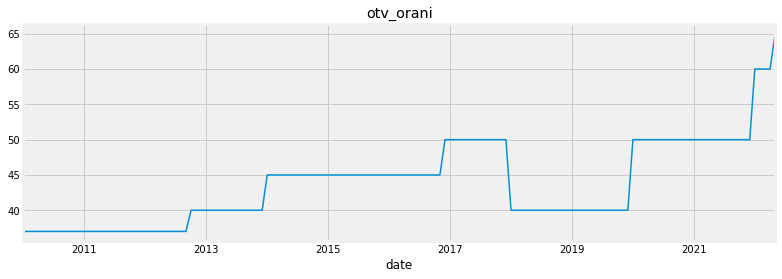

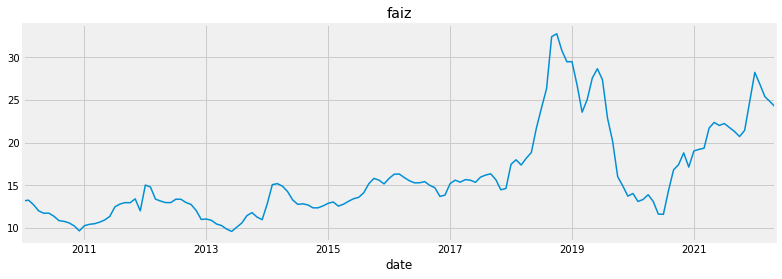

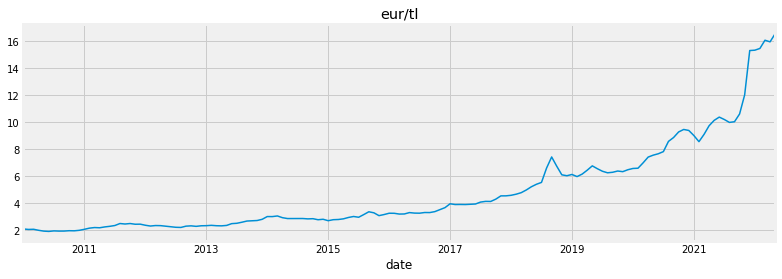

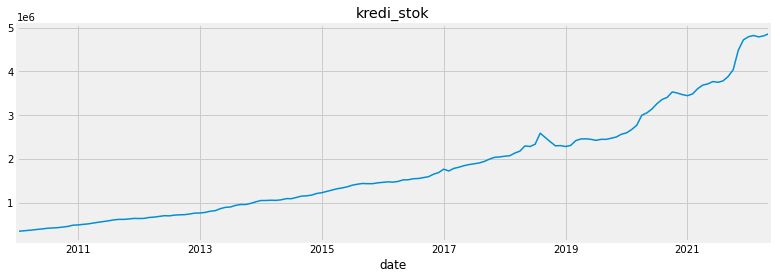

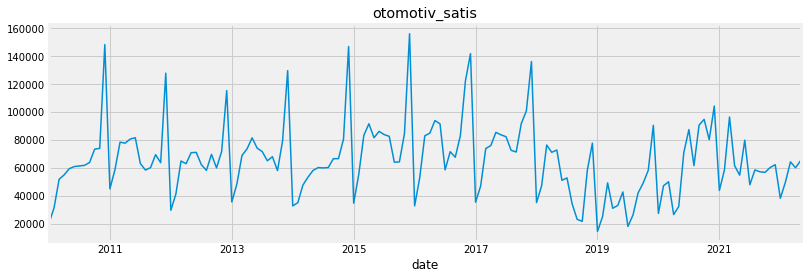

In [76]:
for i in df.columns:
    plt.figure(figsize=(12,4))
    df[i].plot()
    plt.title(i)
    plt.show()

### Adding Date Features

In [77]:
df["month"] = df.index.month
df["year"] = df.index.year
df["quarter"] = df.index.quarter
df['series'] = np.arange(1,len(df)+1)
df["first_quarter"] = df.quarter.apply(lambda x : 1 if x== 1 else 0)
df["last_quarter"] = df.quarter.apply(lambda x: 1 if x== 4 else 0)

### Rolling Mean

In [78]:
df['rolling_mean_3'] = df['otomotiv_satis'].rolling(3).mean()

In [79]:
df = df.bfill()

### Correlation Analysis

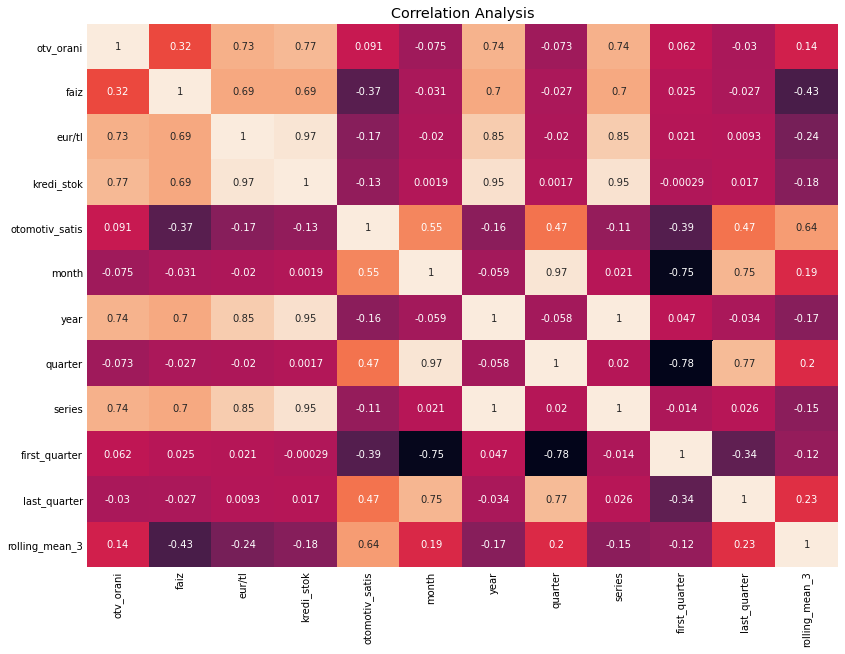

In [80]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cbar=False)
plt.title('Correlation Analysis')
plt.show()

In [81]:
steps = 25
data_train = df[:-steps]
data_test  = df[-steps:]

Train dates : 2010-01-01 00:00:00 --- 2020-04-01 00:00:00  (n=124)
Test dates  : 2020-05-01 00:00:00 --- 2022-05-01 00:00:00  (n=25)


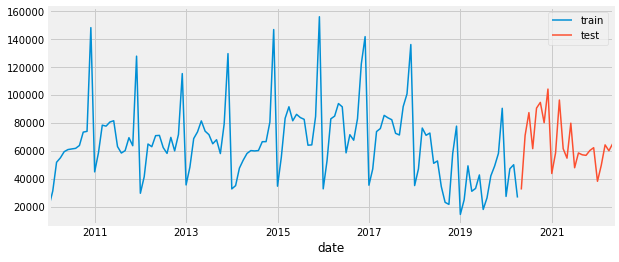

In [82]:
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['otomotiv_satis'].plot(ax=ax, label='train')
data_test['otomotiv_satis'].plot(ax=ax, label='test')
ax.legend();

### Baseline Model with Lags

In [83]:
forecaster = ForecasterAutoreg(
                    regressor = Ridge(.1),
                    lags      = 15
                    
                )

forecaster.fit(
        y = data_train['otomotiv_satis'],
        
            )

In [84]:
steps = 25
predictions = forecaster.predict(steps)

In [85]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test['otomotiv_satis'],
                y_pred = predictions
            )

print(f"Test error (mape):% {round((error_mape),3)*100}")

Test error (mape):% 20.9


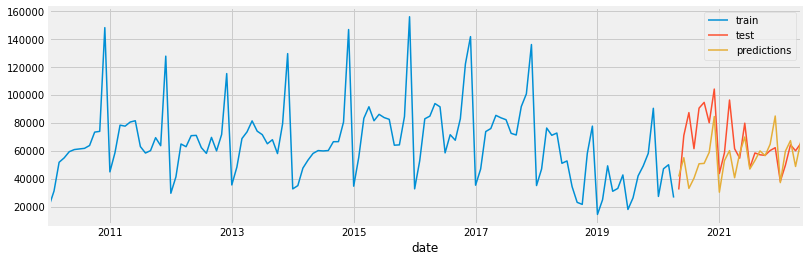

In [86]:
fig, ax=plt.subplots(figsize=(12, 4))
data_train['otomotiv_satis'].plot(ax=ax, label='train')
data_test['otomotiv_satis'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Forecasting with Features

In [87]:
features = ['month','year','quarter',"faiz","rolling_mean_3","kredi_stok",""]

In [88]:
forecaster2 = ForecasterAutoreg(
                    regressor = Ridge(.1),
                    lags      = 15
                    
                )

forecaster2.fit(
    y    = data_train['otomotiv_satis'],
    exog = data_train[features]
)

### Predictions with Features

In [89]:
steps = 25
predictions2 = forecaster2.predict(steps=steps,exog = data_train[features])

In [90]:
error_mape = mean_absolute_percentage_error(
                y_true = data_test['otomotiv_satis'],
                y_pred = predictions2
            )

print(f"Test error (mape):% {round((error_mape),2)*100}")

Test error (mape):% 31.0


### Plotting with Test and Prediction

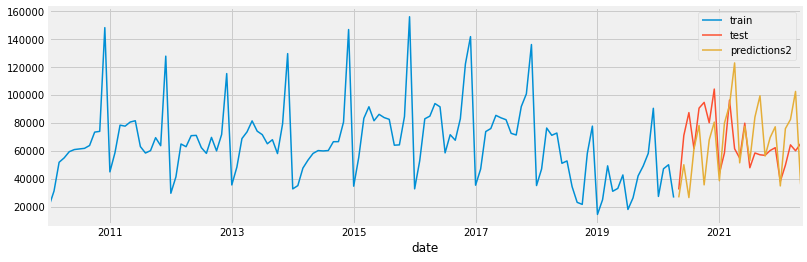

In [91]:
fig, ax=plt.subplots(figsize=(12, 4))
data_train['otomotiv_satis'].plot(ax=ax, label='train')
data_test['otomotiv_satis'].plot(ax=ax, label='test')
predictions2.plot(ax=ax, label='predictions2')
ax.legend();

### Backtesting

In [92]:
n_backtest = 25 # Last 3 months are used for backtest
data_train = df[:-n_backtest]
data_test  = df[-n_backtest:]

forecaster3 = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster3,
                                    y          = df['otomotiv_satis'],
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_absolute_percentage_error',
                                    verbose    = True
                               )

print(f"Error of backtest: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 124
Number of observations used for backtesting: 25
    Number of folds: 3
    Number of steps per fold: 10
    Last fold only includes 5 observations.

Data partition in fold: 0
    Training:   2010-01-01 00:00:00 -- 2020-04-01 00:00:00  (n=124)
    Validation: 2020-05-01 00:00:00 -- 2021-02-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   2010-01-01 00:00:00 -- 2020-04-01 00:00:00  (n=124)
    Validation: 2021-03-01 00:00:00 -- 2021-12-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   2010-01-01 00:00:00 -- 2020-04-01 00:00:00  (n=124)
    Validation: 2022-01-01 00:00:00 -- 2022-05-01 00:00:00  (n=5)

Error of backtest: 0.28987253030901683


#### Predicting 2022 June - 2023 June

In [63]:
# Model starts predicting from 2022 May recursively

In [93]:
result = forecaster.predict(38).tail(13).to_frame()

In [94]:
result

,pred
2022-06-01,75334.973713
2022-07-01,52062.950842
2022-08-01,58188.335866
2022-09-01,63357.121213
2022-10-01,58267.150301
2022-11-01,67341.510781
2022-12-01,83157.501533
2023-01-01,40809.398093
2023-02-01,62600.433519
2023-03-01,69504.188992


In [581]:
save_forecaster(forecaster, file_name='forecaster.pkl', verbose=False)

In [582]:
forecaster_loaded = load_forecaster('forecaster.pkl')

ForecasterAutoreg 
Regressor: Ridge(alpha=0.1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-01 00:00:00'), Timestamp('2020-04-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-11-20 21:26:18 
Last fit date: 2022-11-20 21:26:18 
Skforecast version: 0.5.1 
Python version: 3.8.8 

